<a href="https://colab.research.google.com/github/parasgulati8/Data-Analysis/blob/master/Pathrise_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
cd drive/'My Drive'/'Colab Notebooks'/'Pathrise Assignment'/

[Errno 2] No such file or directory: 'drive/My Drive/Colab Notebooks/Pathrise Assignment/'
/content/drive/My Drive/Colab Notebooks/Pathrise Assignment


In [ ]:
# !pip install pycaret

# 1. Important Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn import preprocessing 
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn.metrics import classification_report, r2_score
from functools import reduce
from scipy.stats import norm
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances
from functools import reduce
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import KernelPCA, PCA
from sklearn.model_selection import GridSearchCV, KFold

# 2. Getting Data

In [ ]:
data = pd.read_excel('data_Pathrise.xlsx')

In [ ]:
data.head()

,id,pathrise_status,primary_track,cohort_tag,program_duration_days,placed,employment_status,highest_level_of_education,length_of_job_search,biggest_challenge_in_search,professional_experience,work_authorization_status,number_of_interviews,number_of_applications,gender,race
0,1,Active,SWE,OCT19A,NaN,0,Unemployed,Bachelor's Degree,3-5 months,Hearing back on my applications,3-4 years,Canada Citizen,2.0,900,Male,Non-Hispanic White or Euro-American
1,2,Active,PSO,JAN20A,NaN,0,Unemployed,"Some College, No Degree",3-5 months,Getting past final round interviews,1-2 years,Citizen,6.0,0,Male,Non-Hispanic White or Euro-American
2,3,Closed Lost,Design,AUG19B,0.0,0,Employed Part-Time,Master's Degree,Less than one month,Figuring out which jobs to apply for,Less than one year,Citizen,0.0,0,Male,East Asian or Asian American
3,4,Closed Lost,PSO,AUG19B,0.0,0,Contractor,Bachelor's Degree,Less than one month,Getting past final round interviews,Less than one year,Citizen,5.0,25,Male,Decline to Self Identify
4,5,Placed,SWE,AUG19A,89.0,1,Unemployed,Bachelor's Degree,1-2 months,Hearing back on my applications,1-2 years,F1 Visa/OPT,10.0,100,Male,East Asian or Asian American


# 3. Data Cleaning 

## 3.1 Dealing with NaN values of program_duration_days

In [ ]:
data.isna().sum()

id                               0
pathrise_status                  0
primary_track                    0
cohort_tag                       8
program_duration_days          616
placed                           0
employment_status              229
highest_level_of_education      58
length_of_job_search            74
biggest_challenge_in_search     24
professional_experience        222
work_authorization_status      284
number_of_interviews           218
number_of_applications           0
gender                         492
race                            18
dtype: int64

In [ ]:
def fillna_program_duration(data1):
  '''
  Fill NaN values in program_duration_days with the median value in same cohort_tag

  input: data1 : pandas DataFrame read from the csv file
  returns: data2 : pandas DataFrame after filling the NaN values in program_duration_days
  '''
  data2 = pd.DataFrame(columns= data1.columns)
  for i in data1.cohort_tag.unique():
    med = data1[data1.cohort_tag == i]['program_duration_days'].median()
    temp = data1[data1.cohort_tag == i].fillna(value = {'program_duration_days':med})
    
    data2 = pd.concat([data2, temp])

  return data2

In [ ]:
data = fillna_program_duration(data)

## 3.2 Converting the categorcal value to numerical values. 

<h3>It helps the model to establish relationships between feature in a better way


In [ ]:
def clean_data(data):
  '''
  modifies the professional_experience, length_of_job_search and highest_level_of_education columns of the data.

  Changes in professional_experience are as follows: '1-2 years':2, '3-4 years':3, 'Less than one year':1, '5+ years':4, np.nan:0
  Changes in length_of_job_search are as follows: 'Less than one month':1, '1-2 months':2, '3-5 months':3,
        '6 months to a year':4, 'Over a year':5, np.nan:0
  Changes in highest_level_of_education are as follows: "Bachelor's Degree":3, "Master's Degree":4, 'Some College, No Degree':0,
        'Some High School':1, 'Doctorate or Professional Degree':5,
        'High School Graduate':2, np.nan:0, 'GED or equivalent':2
        
  '''
  placed = data.copy()
  placed.professional_experience.replace({'1-2 years':2, '3-4 years':3, 'Less than one year':1, '5+ years':4, np.nan:0}, inplace=True)
  placed.length_of_job_search.replace({'Less than one month':1, '1-2 months':2, '3-5 months':3,
        '6 months to a year':4, 'Over a year':5, np.nan:0}, inplace = True)

  placed.highest_level_of_education.replace({"Bachelor's Degree":3, "Master's Degree":4, 'Some College, No Degree':0,
        'Some High School':1, 'Doctorate or Professional Degree':5,
        'High School Graduate':2, np.nan:0, 'GED or equivalent':2}, inplace =True)
  placed = placed.drop(columns=['id', 'cohort_tag', 'race', 'gender'])
  placed1 =  pd.get_dummies(placed, columns=['primary_track', 'employment_status ', 'biggest_challenge_in_search', 'work_authorization_status', 'pathrise_status' ], drop_first=True).fillna(0)

  return placed1

In [ ]:
data1 = clean_data(data)

In [ ]:
data1.head()

,program_duration_days,placed,highest_level_of_education,length_of_job_search,professional_experience,number_of_interviews,number_of_applications,primary_track_Design,primary_track_Marketing,primary_track_PSO,primary_track_SWE,primary_track_Web,employment_status _Employed Full-Time,employment_status _Employed Part-Time,employment_status _Student,employment_status _Unemployed,biggest_challenge_in_search_Figuring out which jobs to apply for,biggest_challenge_in_search_Getting past final round interviews,biggest_challenge_in_search_Getting past mid-stage interviews,biggest_challenge_in_search_Getting past phone screens,biggest_challenge_in_search_Hearing back on my applications,biggest_challenge_in_search_Lack of relevant experience,biggest_challenge_in_search_Resume gap,biggest_challenge_in_search_Technical interviewing,biggest_challenge_in_search_Technical skills,work_authorization_status_Citizen,work_authorization_status_F1 Visa/CPT,work_authorization_status_F1 Visa/OPT,work_authorization_status_Green Card,work_authorization_status_H1B,work_authorization_status_Not Authorized,work_authorization_status_Other,work_authorization_status_STEM OPT,pathrise_status_Break,pathrise_status_Closed Lost,pathrise_status_Deferred,pathrise_status_MIA,pathrise_status_Placed,pathrise_status_Withdrawn,pathrise_status_Withdrawn (Failed),pathrise_status_Withdrawn (Trial)
0,55.5,0,3,3,3,2.0,900,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12,12.0,0,3,4,2,3.0,10,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
13,52.0,0,3,2,1,4.0,40,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
56,26.0,0,4,2,3,7.0,6,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
223,55.5,0,5,4,0,0.0,30,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
enrolled_unplaced = data1[(data1.placed == 0) & (data.pathrise_status == 'Active')]
ultimately_unplaced = data1[(data.placed == 0)  & (data.pathrise_status != 'Active')]
placed = data1[data.placed == 1]

# 4. Data Wrangling and Visualization

## 4.1. Distribution of Pathrise Fellows in Different Tracks and Status  

In [ ]:
track_counts = reduce(lambda x,y : pd.merge(x, y, how = 'left', left_index=True, right_index=True), [data[(data.placed == 0) & (data.pathrise_status == 'Active')].primary_track.value_counts(), 
                                                                                                      data[(data.placed == 0)  & (data.pathrise_status != 'Active')].primary_track.value_counts(), 
                                                                                                     data[data.placed == 1].primary_track.value_counts()])

track_counts =track_counts.rename(columns = {'primary_track_x': 'enrolled_unplaced', 'primary_track_y':'ultimately_unplaced', 'primary_track': 'placed'})
track_counts.fillna(0, inplace=True)

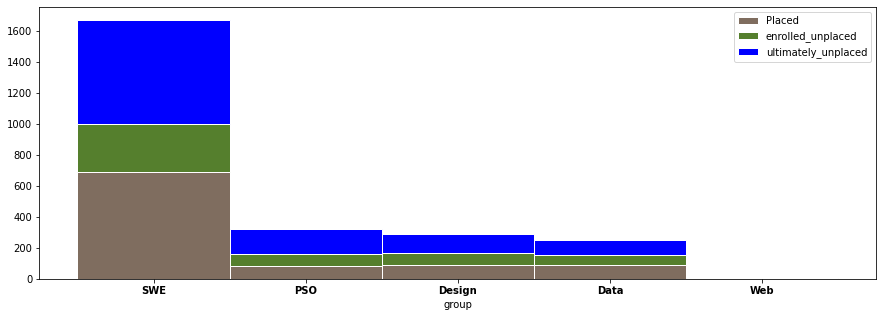

In [ ]:
plt.figure(figsize=(15,5))

# Values of each group
bars1 = track_counts.placed
bars2 = track_counts.enrolled_unplaced
bars3 = track_counts.ultimately_unplaced
 
# Heights of bars1 + bars2
bars = np.add(bars1, bars2).tolist()
 
# The position of the bars on the x-axis
r = range(len(track_counts))
 
# Names of group and bar width
names = track_counts.index
barWidth = 1
 
# Create brown bars
plt.bar(r, bars1, color='#7f6d5f', edgecolor='white', width=barWidth, label = 'Placed')
# Create green bars (middle), on top of the firs ones
plt.bar(r, bars2, bottom=bars1, color='#557f2d', edgecolor='white', width=barWidth, label = 'enrolled_unplaced')
# Create green bars (top)
plt.bar(r, bars3, bottom=bars, color='b', edgecolor='white', width=barWidth, label= 'ultimately_unplaced')

# Custom X axis
plt.xticks(r, names, fontweight='bold')
plt.xlabel("group")

plt.legend() 
# Show graphic
plt.show()

**<h1>Points to note:</h1>**

1) Most of the placed fellows belong to SWE track. 

2) Only one fellow placed from Web and Marketing tracks

3) For PSO track, most of the fellows found their job in less than a month

4) For SWE, Data, and Design tracks, most of the fellows found their job in 1-2 month

## 4.2. Plotting Number of Applications vs Number of Interviews



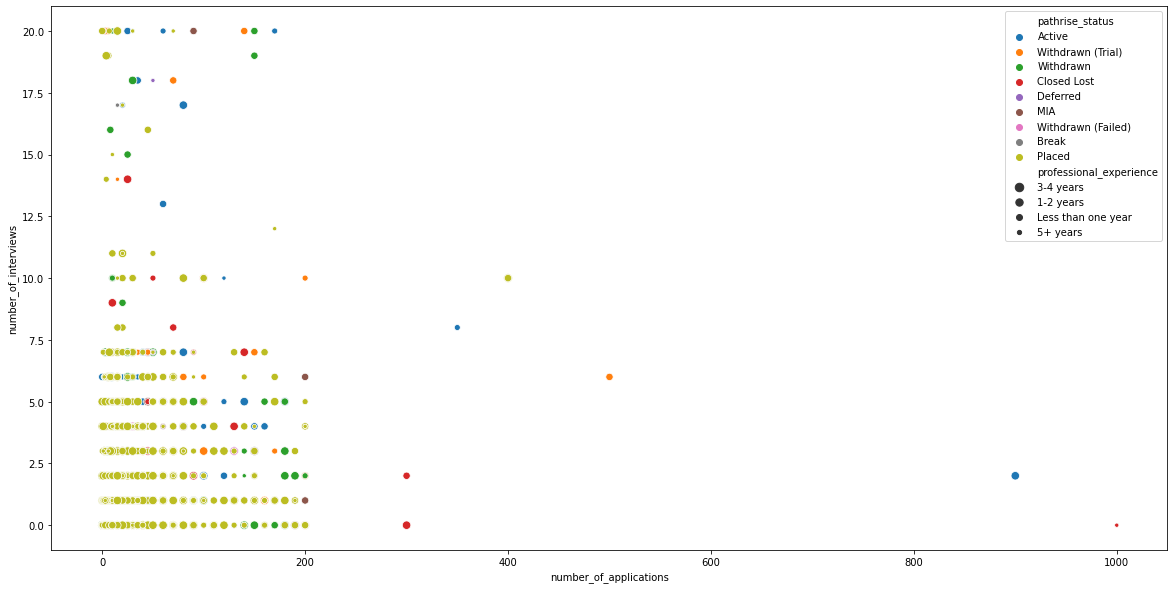

In [ ]:
plt.figure(figsize=(20,10))
sns.scatterplot(x = 'number_of_applications', y = 'number_of_interviews' , hue = 'pathrise_status', data=pd.concat([data[(data.placed == 0) & (data.pathrise_status == 'Active')], 
                                                                                                      data[(data.placed == 0)  & (data.pathrise_status != 'Active')], 
                                                                                                     data[data.placed == 1]]),
                 size='professional_experience')

## 4.3. Analysing Distribution of Placed Students

In [ ]:
def gaussian(placed1):
  '''
  Calculates the multivariate gaussian probability of input dataframe across all features

  input: pandas Dataframe
  returns: list of probabilities for all sample in sorted order
  '''
  scaler = preprocessing.MinMaxScaler()
  x = placed1.values
  x_scaled = scaler.fit_transform(x)
  placed1 = pd.DataFrame(x_scaled)

  placed1_mean = placed1.describe().iloc[1, :]
  placed1_std = placed1.describe().iloc[2,:]
  p1 = []
  for i in range(len(placed1_mean)):
    p1.append(norm.pdf( placed1.iloc[:,i].values, placed1_mean[i], placed1_std[i]))
  p1 = np.array(p1).reshape((-1,len(p1)))
  p1 = pd.DataFrame(p1).dropna().values
  p1 = np.product(p1, axis = 1)
  return sorted(p1)

In [ ]:
p1 = gaussian(placed)
p2 = gaussian(ultimately_unplaced)
p3 = gaussian(enrolled_unplaced)

/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1740: RuntimeWarning: invalid value encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:899: RuntimeWarning: invalid value encountered in greater_equal
  return (a <= x) & (x <= b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:899: RuntimeWarning: invalid value encountered in less_equal
  return (a <= x) & (x <= b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1740: RuntimeWarning: invalid value encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:899: RuntimeWarning: invalid value encountered in greater_equal
  return (a <= x) & (x <= b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:899: RuntimeWarning: invalid value encountered in 

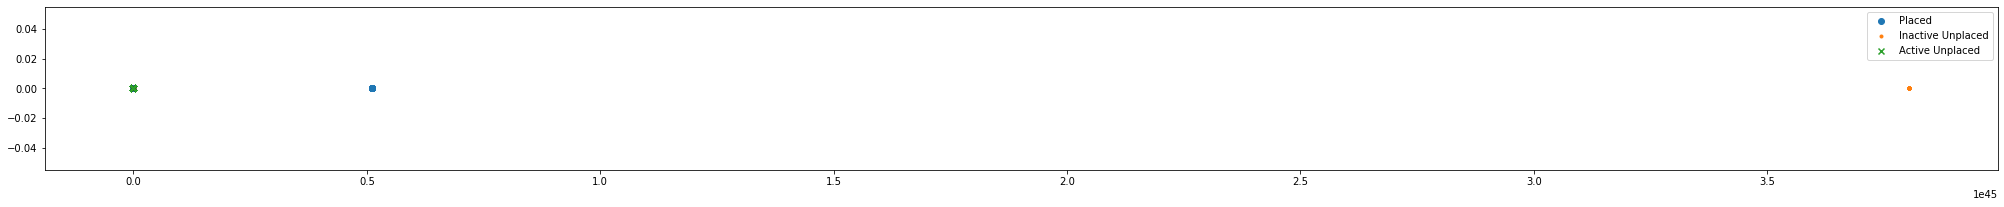

In [ ]:
plt.figure(figsize=(35,3))

plt.scatter(p1, [0]*len(p1), label = 'Placed', marker='o', norm = True)
plt.scatter(p2, [0]*len(p2), label = 'Inactive Unplaced', marker='.', norm = True)
plt.scatter(p3, [0]*len(p3), label = 'Active Unplaced', marker='x', norm=True)
plt.legend()
plt.show()

<h2>This Plot shows that the avtive unplaced are close to Placed in terms of probability and in some cases overlapping with placed. Ultimately unplaced students are those who either withdrawn from the program and failed to get placed while. </h2>


# 5. Predicting if the student will utimately be placed

In [ ]:
similarity_placed = cosine_similarity(placed.values,  placed.values).mean(axis = 1)

In [ ]:
threshold = 0.7
print((similarity_placed > threshold).sum(), (similarity_placed <= threshold).sum())
print('accuracy = ', (similarity_placed > threshold).sum()/ len(similarity_placed))

899 55
accuracy =  0.9423480083857443


In [ ]:
similarity_enrolled_unplaced = cosine_similarity(enrolled_unplaced.values, placed.values).mean(axis = 1)
print((similarity_enrolled_unplaced > threshold).sum(), (similarity_enrolled_unplaced <= threshold).sum())
print('Prediction = ', (similarity_enrolled_unplaced > threshold).sum()/ len(similarity_enrolled_unplaced))

443 87
Prediction =  0.8358490566037736


In [ ]:
enrolled_unplaced['student_will_get_placed'] = similarity_enrolled_unplaced > threshold

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
predictions = pd.merge(data[['id']], enrolled_unplaced[['student_will_get_placed']], left_index=True, right_index=True)

In [ ]:
predictions

,id,student_will_get_placed
0,1,False
223,224,True
391,392,True
393,394,False
464,465,False
...,...,...
2019,2020,True
2227,2228,True
2409,2410,True
1721,1722,True


# 6.Predicting the duration it will take to get placed

## 6.1. Random Forest

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(placed.drop(columns=['program_duration_days']), placed.program_duration_days, test_size = 0.2, random_state = 0)

In [ ]:
regressor = RandomForestRegressor(100, random_state=0)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
r2_score(y_test, y_pred)

-0.14750085071282282

In [ ]:
regressor.score(X_train, y_train)

0.8504467717266132

## 6.2 Evaluating the feature importances


In [ ]:
pd.Series(regressor.feature_importances_, index=placed.drop(columns=['program_duration_days']).columns).sort_values(ascending =False)

number_of_applications                                              0.211023
number_of_interviews                                                0.102410
length_of_job_search                                                0.098034
professional_experience                                             0.092051
highest_level_of_education                                          0.074091
employment_status _Student                                          0.033571
primary_track_SWE                                                   0.028779
work_authorization_status_Citizen                                   0.028299
biggest_challenge_in_search_Hearing back on my applications         0.027944
work_authorization_status_F1 Visa/OPT                               0.027228
employment_status _Unemployed                                       0.027111
biggest_challenge_in_search_Getting past final round interviews     0.025925
employment_status _Employed Full-Time                               0.023457

## 6.3 SVR

In [ ]:
scaler = preprocessing.MinMaxScaler()

In [ ]:
X_train_ = scaler.fit_transform(X_train)
X_test_ = scaler.transform(X_test)

In [ ]:
regressor = SVR(kernel='poly', degree=5)
regressor.fit(X_train_, y_train)
y_pred = regressor.predict(X_test_)
print(regressor.score(X_train_, y_train))
print(r2_score(y_test, y_pred))

0.013571047391622737
-0.06716702346649339


## 6.4 Linear Regression

In [ ]:
regressor = LinearRegression()
regressor.fit(X = (X_train), y=(y_train))
y_pred = regressor.predict(X_test_)
r2_score(y_test, y_pred)

-0.04846288763640638

## 6.5 Feature Extraction


### 6.5.1 LDA

In [ ]:
lda = LDA()
X_train_original_lda = lda.fit_transform(X_train, y_train)
X_test_original_lda = lda.transform(X_test)

In [ ]:
regressor = RandomForestRegressor(500, random_state=0, min_impurity_split=5, min_samples_split=5)
regressor.fit(X_train_original_lda, y_train)
y_pred = regressor.predict(X_test_original_lda)
r2_score(y_test, y_pred)

/usr/local/lib/python3.6/dist-packages/sklearn/tree/_classes.py:301: FutureWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/tree/_classes.py:301: FutureWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/tree/_classes.py:301: FutureWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/tree/_classes.py:301: FutureWarning: The min_impurity_split parameter is depr

-0.06801153301001928

### 6.5.2 PCA

In [ ]:
pca = PCA(n_components=None)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [ ]:
regressor = RandomForestRegressor(500, random_state=0, max_features=30)
regressor.fit(X_train_pca, y_train)
y_pred = regressor.predict(X_test_pca)
r2_score(y_test, y_pred)

-0.08000400687889142

### 6.5.3 Kernel PCA

In [ ]:
kpca = KernelPCA(kernel='rbf')
X_train_original_kpca= kpca.fit_transform(X_train)
X_test_original_kpca = kpca.transform(X_test)

In [ ]:
regressor = RandomForestRegressor(500, random_state=0, max_features=30)
regressor.fit(X_train_original_kpca, y_train)
y_pred = regressor.predict(X_test_original_kpca)
r2_score(y_test, y_pred)

-0.0013782001815587641

In [ ]:
regressor.score(X_train_original_kpca, y_train)

0.8611059247967452

## 6.6 Feature Engineering


### 6.6.1 Splitting program duration days in bins of width 10
It is difficult to get an exact estimate of number of days it will take until the student is placed. So we split the 'program_duration_days' into smaller bins and try to estimate the length of the job search. 

The program_duration_days is originally a continuous valued feature and we will try to partition it into different bins. 

Before (placed):

Index | program_duration_days
--- | ---
407   |   59.0 
478   |  46.0 
490   |  94.0
513   |  24.0
1237  |  34.0


After (placed1):

Index | program_duration_days
--- | ---
407  |   50.0
478  |   40.0
490  |   90.0
513  |   20.0
1237 |   30.0


In [ ]:
placed1 = placed.copy()
placed1.program_duration_days = (placed.program_duration_days  - (placed.program_duration_days % 10))

In [ ]:
def rf_regressor(data):
  placed = data.copy()
  placed.dropna(inplace=True)
  X_train, X_test, y_train, y_test = train_test_split(placed.drop(columns=['program_duration_days']), placed.program_duration_days, test_size = 0.2, random_state = 0)  
  regressor = RandomForestRegressor(100, random_state=0)
  regressor.fit(X_train, y_train)
  y_pred = regressor.predict(X_test)
  return r2_score(y_test, y_pred)

In [ ]:
rf_regressor(placed1)

-0.14398598070520552

### 6.6.2 Splitting program duration days in bins of width 15

Before (placed):

Index | program_duration_days
--- | ---
407   |   59.0 
478   |  46.0 
490   |  94.0
513   |  24.0
1237  |  34.0


After (placed2):

Index | program_duration_days
--- | ---
407  |    60
478  |    60
490  |   105
513  |    30
1237 |    45

Categories (36, int64): [15 < 30 < 45 < 60 ... 495 < 510 < 525 < 540]


In [ ]:
placed2 = placed.copy()
placed2.program_duration_days = pd.cut(placed.program_duration_days, range(0,550, 15), include_lowest=True, labels= [i*15 for i in range(1,37)])
rf_regressor(placed2)

-0.10849678562507181

### 6.6.3 Splitting program duration days in bins of width 30

Before (placed):

Index | program_duration_days
--- | ---
407   |   59.0 
478   |  46.0 
490   |  94.0
513   |  24.0
1237  |  34.0


After (placed3):

Index | program_duration_days
--- | ---
407  |    60
478  |    60
490  |   120
513  |    30
1237 |    60

Categories (18, int64): [30 < 60 < 90 < 120 ... 450 < 480 < 510 < 540]


In [ ]:
placed3 = placed.copy()
placed3.program_duration_days =pd.cut(placed.program_duration_days, range(0,550, 30), include_lowest=True, labels= [i*30 for i in range(1,19)])
rf_regressor(placed3)

-0.09258632327461758

#### 6.6.3.1 Adding cosine sililarity feature to the data

<h1>The approach is sligtly improving the R-squared score. However, the score is still in negatives which means the predictions are pretty random. Thus this method is not suitable for prediction.

<h2>Let's include the **cosine similarity** feature to the dataset and evaluate the predictions

In [ ]:
placed3['cosine_similarity'] = similarity_placed
rf_regressor(placed3)

0.7797648699517347

### KFold CV

In [ ]:
def kfold(data):
  placed = data.copy()
  placed.dropna(inplace=True)
  X,y = placed.drop(columns=['program_duration_days']), placed.program_duration_days
  kfolds = KFold(shuffle=True, random_state=0)
  folds =  kfolds.split(X,y)
  return folds

In [ ]:
def cv(data):
  placed = data.copy()
  placed.dropna(inplace=True)
  
  y_test_r2_score_ = []
  folds = kfold(placed3)
  X,y = placed.drop(columns=['program_duration_days']), placed.program_duration_days

  for fold in folds:
    X_train, X_test, y_train, y_test = X.values[fold[0]], X.values[fold[1]], y.values[fold[0]], y.values[fold[1]]
    regressor = RandomForestRegressor(100, random_state=0)
    regressor.fit(X_train, y_train)
    y_test_r2_score_.append(regressor.score(X_test, y_test))

  return np.array(y_test_r2_score_).mean()


In [ ]:
cv(placed3)

0.6958803630334769

<h1>The accuracy is about 69.5%. we can tune the hyperparameters by using GridSearch and try to further enhance the accuracy of the model. </h1> 


### GridSearch CV for hyperparameter tuning


In [ ]:
def gridsearch_cv(data, parameters):
  placed = data.copy()
  placed.dropna(inplace=True)
  X, y = placed.drop(columns=['program_duration_days']), placed.program_duration_days

  rf = RandomForestRegressor(random_state=0)

  grid_cv = GridSearchCV(rf, parameters, verbose=10, return_train_score=True)
  grid_cv.fit(X,y)
  
  return grid_cv

In [ ]:
params = {'n_estimators':[100,150,200,250,300, 400, 500],'min_samples_leaf':[1], 'min_samples_split':[2]}
grid_cv = gridsearch_cv(placed3, params)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
[CV] min_samples_leaf=1, min_samples_split=2, n_estimators=100 .......


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  min_samples_leaf=1, min_samples_split=2, n_estimators=100, score=(train=0.954, test=0.726), total=   0.4s
[CV] min_samples_leaf=1, min_samples_split=2, n_estimators=100 .......


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV]  min_samples_leaf=1, min_samples_split=2, n_estimators=100, score=(train=0.958, test=0.767), total=   0.4s
[CV] min_samples_leaf=1, min_samples_split=2, n_estimators=100 .......


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s remaining:    0.0s


[CV]  min_samples_leaf=1, min_samples_split=2, n_estimators=100, score=(train=0.960, test=0.620), total=   0.4s
[CV] min_samples_leaf=1, min_samples_split=2, n_estimators=100 .......


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.3s remaining:    0.0s


[CV]  min_samples_leaf=1, min_samples_split=2, n_estimators=100, score=(train=0.955, test=0.703), total=   0.4s
[CV] min_samples_leaf=1, min_samples_split=2, n_estimators=100 .......


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.7s remaining:    0.0s


[CV]  min_samples_leaf=1, min_samples_split=2, n_estimators=100, score=(train=0.962, test=0.689), total=   0.4s
[CV] min_samples_leaf=1, min_samples_split=2, n_estimators=150 .......


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.1s remaining:    0.0s


[CV]  min_samples_leaf=1, min_samples_split=2, n_estimators=150, score=(train=0.955, test=0.721), total=   0.6s
[CV] min_samples_leaf=1, min_samples_split=2, n_estimators=150 .......


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    2.7s remaining:    0.0s


[CV]  min_samples_leaf=1, min_samples_split=2, n_estimators=150, score=(train=0.958, test=0.766), total=   0.6s
[CV] min_samples_leaf=1, min_samples_split=2, n_estimators=150 .......


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    3.4s remaining:    0.0s


[CV]  min_samples_leaf=1, min_samples_split=2, n_estimators=150, score=(train=0.961, test=0.625), total=   0.6s
[CV] min_samples_leaf=1, min_samples_split=2, n_estimators=150 .......


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    4.0s remaining:    0.0s


[CV]  min_samples_leaf=1, min_samples_split=2, n_estimators=150, score=(train=0.956, test=0.704), total=   0.6s
[CV] min_samples_leaf=1, min_samples_split=2, n_estimators=150 .......


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    4.6s remaining:    0.0s


[CV]  min_samples_leaf=1, min_samples_split=2, n_estimators=150, score=(train=0.961, test=0.687), total=   0.6s
[CV] min_samples_leaf=1, min_samples_split=2, n_estimators=200 .......
[CV]  min_samples_leaf=1, min_samples_split=2, n_estimators=200, score=(train=0.956, test=0.721), total=   0.8s
[CV] min_samples_leaf=1, min_samples_split=2, n_estimators=200 .......
[CV]  min_samples_leaf=1, min_samples_split=2, n_estimators=200, score=(train=0.958, test=0.760), total=   0.8s
[CV] min_samples_leaf=1, min_samples_split=2, n_estimators=200 .......
[CV]  min_samples_leaf=1, min_samples_split=2, n_estimators=200, score=(train=0.961, test=0.630), total=   0.8s
[CV] min_samples_leaf=1, min_samples_split=2, n_estimators=200 .......
[CV]  min_samples_leaf=1, min_samples_split=2, n_estimators=200, score=(train=0.957, test=0.705), total=   0.8s
[CV] min_samples_leaf=1, min_samples_split=2, n_estimators=200 .......
[CV]  min_samples_leaf=1, min_samples_split=2, n_estimators=200, score=(train=0.962, 

[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:   38.2s finished


In [ ]:
grid_cv.best_score_

0.7025241815370287

In [ ]:
grid_cv.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=500, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

In [ ]:
params = {'n_estimators':[100,150,200,250,300] ,'min_samples_leaf':[1, 2, 5, 10, 20], 'min_samples_split':[2,4,6,8,10]}
grid_cv = gridsearch_cv(placed3, params)

Fitting 5 folds for each of 125 candidates, totalling 625 fits
[CV] min_samples_leaf=1, min_samples_split=2, n_estimators=100 .......


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  min_samples_leaf=1, min_samples_split=2, n_estimators=100, score=(train=0.954, test=0.726), total=   0.4s
[CV] min_samples_leaf=1, min_samples_split=2, n_estimators=100 .......


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV]  min_samples_leaf=1, min_samples_split=2, n_estimators=100, score=(train=0.958, test=0.767), total=   0.4s
[CV] min_samples_leaf=1, min_samples_split=2, n_estimators=100 .......


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s remaining:    0.0s


[CV]  min_samples_leaf=1, min_samples_split=2, n_estimators=100, score=(train=0.960, test=0.620), total=   0.4s
[CV] min_samples_leaf=1, min_samples_split=2, n_estimators=100 .......


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.3s remaining:    0.0s


[CV]  min_samples_leaf=1, min_samples_split=2, n_estimators=100, score=(train=0.955, test=0.703), total=   0.4s
[CV] min_samples_leaf=1, min_samples_split=2, n_estimators=100 .......


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.7s remaining:    0.0s


[CV]  min_samples_leaf=1, min_samples_split=2, n_estimators=100, score=(train=0.962, test=0.689), total=   0.4s
[CV] min_samples_leaf=1, min_samples_split=2, n_estimators=150 .......


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.1s remaining:    0.0s


[CV]  min_samples_leaf=1, min_samples_split=2, n_estimators=150, score=(train=0.955, test=0.721), total=   0.6s
[CV] min_samples_leaf=1, min_samples_split=2, n_estimators=150 .......


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    2.7s remaining:    0.0s


[CV]  min_samples_leaf=1, min_samples_split=2, n_estimators=150, score=(train=0.958, test=0.766), total=   0.6s
[CV] min_samples_leaf=1, min_samples_split=2, n_estimators=150 .......


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    3.3s remaining:    0.0s


[CV]  min_samples_leaf=1, min_samples_split=2, n_estimators=150, score=(train=0.961, test=0.625), total=   0.6s
[CV] min_samples_leaf=1, min_samples_split=2, n_estimators=150 .......


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    3.9s remaining:    0.0s


[CV]  min_samples_leaf=1, min_samples_split=2, n_estimators=150, score=(train=0.956, test=0.704), total=   0.6s
[CV] min_samples_leaf=1, min_samples_split=2, n_estimators=150 .......


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    4.5s remaining:    0.0s


[CV]  min_samples_leaf=1, min_samples_split=2, n_estimators=150, score=(train=0.961, test=0.687), total=   0.6s
[CV] min_samples_leaf=1, min_samples_split=2, n_estimators=200 .......
[CV]  min_samples_leaf=1, min_samples_split=2, n_estimators=200, score=(train=0.956, test=0.721), total=   0.8s
[CV] min_samples_leaf=1, min_samples_split=2, n_estimators=200 .......
[CV]  min_samples_leaf=1, min_samples_split=2, n_estimators=200, score=(train=0.958, test=0.760), total=   0.8s
[CV] min_samples_leaf=1, min_samples_split=2, n_estimators=200 .......
[CV]  min_samples_leaf=1, min_samples_split=2, n_estimators=200, score=(train=0.961, test=0.630), total=   0.8s
[CV] min_samples_leaf=1, min_samples_split=2, n_estimators=200 .......
[CV]  min_samples_leaf=1, min_samples_split=2, n_estimators=200, score=(train=0.957, test=0.705), total=   0.8s
[CV] min_samples_leaf=1, min_samples_split=2, n_estimators=200 .......
[CV]  min_samples_leaf=1, min_samples_split=2, n_estimators=200, score=(train=0.962, 

[Parallel(n_jobs=1)]: Done 625 out of 625 | elapsed:  6.3min finished


In [ ]:
grid_cv.best_score_

0.7011823718394504

In [ ]:
grid_cv.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=200, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

# 7. Classification Model: Classifying placed vs unplaced candidates

In [ ]:
from pycaret.classification import *
clf1 = setup(data = data1, target = 'placed')

 
Setup Succesfully Completed!


,Description,Value
0,session_id,1337
1,Target Type,Binary
2,Label Encoded,None
3,Original Data,"(2536, 41)"
4,Missing Values,False
5,Numeric Features,37
6,Categorical Features,3
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


In [ ]:
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,Logistic Regression,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,Naive Bayes,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2,Decision Tree Classifier,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
3,Ridge Classifier,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000
4,Ada Boost Classifier,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
5,Gradient Boosting Classifier,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
6,Extra Trees Classifier,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
7,Extreme Gradient Boosting,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
8,Light Gradient Boosting Machine,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
9,CatBoost Classifier,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


The highlighted models are capable of classifying the placed and unplaced students with 100% accuracy on 10 fold cross validation. 


#Converting notebook to PDF

In [ ]:
!apt-get install texlive texlive-xetex texlive-latex-extra pandoc
!pip install pypandoc

Reading package lists... Done
Building dependency tree       
Reading state information... Done
pandoc is already the newest version (1.19.2.4~dfsg-1build4).
texlive is already the newest version (2017.20180305-1).
texlive-latex-extra is already the newest version (2017.20180305-2).
texlive-xetex is already the newest version (2017.20180305-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 33 not upgraded.


In [ ]:
!cp '/content/drive/My Drive/Colab Notebooks/Pathrise Assignment.ipynb' '/content/drive/My Drive/Colab Notebooks/Pathrise Assignment/'

In [ ]:
!jupyter nbconvert --to PDF 'Pathrise Assignment.ipynb'

[NbConvertApp] Converting notebook Pathrise Assignment.ipynb to PDF
[NbConvertApp] Support files will be in Pathrise Assignment_files/
[NbConvertApp] Making directory ./Pathrise Assignment_files
[NbConvertApp] Making directory ./Pathrise Assignment_files
[NbConvertApp] Making directory ./Pathrise Assignment_files
[NbConvertApp] Writing 378152 bytes to ./notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: [u'xelatex', u'./notebook.tex', '-quiet']
[NbConvertApp] CRITICAL | xelatex failed: [u'xelatex', u'./notebook.tex', '-quiet']
This is XeTeX, Version 3.14159265-2.6-0.99998 (TeX Live 2017/Debian) (preloaded format=xelatex)
 restricted \write18 enabled.
entering extended mode
(./notebook.tex
LaTeX2e <2017-04-15>
Babel <3.18> and hyphenation patterns for 3 language(s) loaded.
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2014/09/29 v1.4h Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size11.clo))

In [ ]:
ls

 catboost_info/      'Pathrise Assignment.ipynb'
 data_Pathrise.xlsx  'Pathrise Assignment.pdf'
